## NBEATSX V3 Test

Using device: cpu
Epoch 0/50, Loss: 293.3773
Epoch 10/50, Loss: 5.7446
Epoch 20/50, Loss: 4.9673
Epoch 30/50, Loss: 5.3068
Epoch 40/50, Loss: 4.3766

Train MSAE: 0.6873, Train RSE: 0.0075
Test MSAE: 0.8347, Test RSE: 0.1238


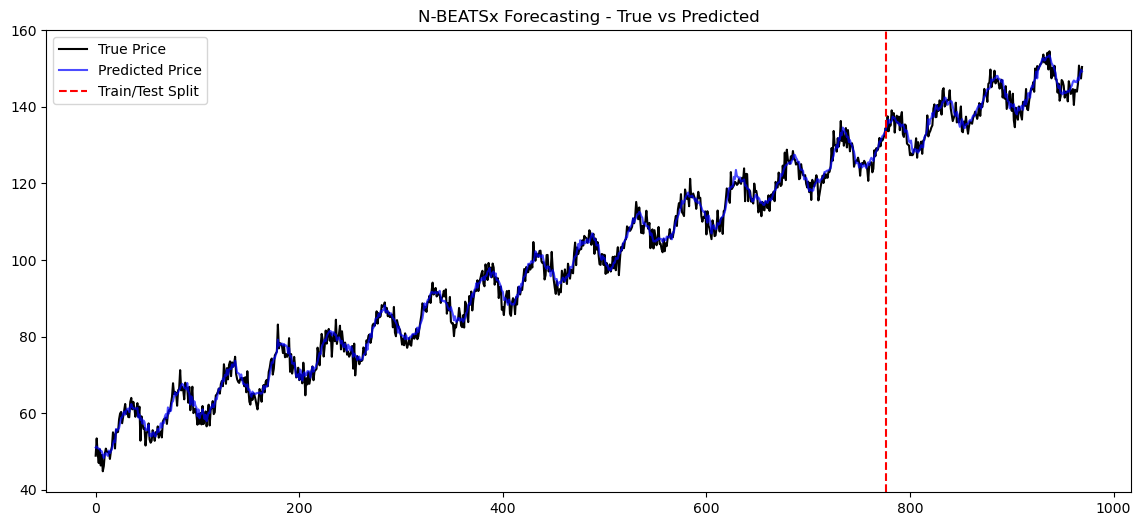


Block 1 (Trend) - Theta Sample:
[122.5798       2.6952617   22.61362     -6.8157897  102.60738
  35.033104     0.53710425 -13.945977  ]

Block 2 (Seasonality) - Theta Sample:
[ 0.69869936  1.5033786   0.3226595   1.118627   -0.75356144  1.4997826
  0.37332314  0.50659215  0.42878157  0.27736002  0.05581229 -1.6664969 ]

Block 3 (Trend) - Theta Sample:
[ 1.3617227  -0.31091577  0.19876727 -0.673508    2.1580222  -0.20300406
 -0.82660925 -1.2012472 ]

Block 4 (Seasonality) - Theta Sample:
[ 1.3265171   2.3212605  -0.07684838  2.2391934  -0.3522878   1.399342
  0.34726095  0.60160434 -0.95766646  0.9790216  -1.0465007   0.93699324]

Sample 1
True Price: 134.47, Predicted Price: 134.02
Trend Contribution: 123.94, Seasonality Contribution: 10.08

Block 1 (Trend) - Theta Sample:
[123.319115    2.6482384  22.701073   -6.897907  102.948555   35.13599
   0.4165274 -13.9165125]

Block 2 (Seasonality) - Theta Sample:
[ 0.6352737   1.5619262   0.12272706  1.1954112  -0.69069976  1.6253824
  0.159

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models.nbeatsx_v3 import NBeatsX  # Adjust if your filename is different

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model Parameters
input_size = 30
exog_size = 3
forecast_size = 1
hidden_units = 256
num_blocks = 4
epochs = 50
batch_size = 32
learning_rate = 0.001

# Create synthetic dataset
np.random.seed(42)
n = 1000
t = np.arange(n)
price = 50 + 0.1 * t + 5 * np.sin(2 * np.pi * t / 50) + np.random.normal(scale=2, size=n)
df = pd.DataFrame({
    'Date': pd.date_range(start="2020-01-01", periods=n),
    'Price': price
})

# Data Preparation
def prepare_data(df, input_size, exog_size):
    prices = df["Price"].values
    dates = df["Date"].values

    # Generate synthetic exogenous factors
    exog_factors = np.random.uniform(0.9, 1.1, size=(len(prices), exog_size))

    X, Y, Exog = [], [], []
    for i in range(len(prices) - input_size):
        X.append(prices[i:i+input_size])
        Y.append(prices[i+input_size])
        Exog.append(exog_factors[i+input_size])
    
    X, Y, Exog = map(lambda x: torch.tensor(x, dtype=torch.float32), (X, Y, Exog))
    return X, Y.unsqueeze(1), Exog

X, Y, Exog = prepare_data(df, input_size, exog_size)

# Train/Test split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]
Exog_train, Exog_test = Exog[:split_idx], Exog[split_idx:]

# Model
model = NBeatsX(
    input_size=input_size,
    exog_size=exog_size,
    forecast_size=forecast_size,
    hidden_units=hidden_units,
    num_blocks=num_blocks
).to(device)

# Training
def train_model(model, X_train, Y_train, Exog_train, epochs, batch_size, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size].to(device)
            y_batch = Y_train[i:i+batch_size].to(device)
            exog_batch = Exog_train[i:i+batch_size].to(device)

            optimizer.zero_grad()
            preds = model(x_batch, exog_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        losses.append(epoch_loss / (len(X_train) // batch_size))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {losses[-1]:.4f}")
    
    return losses

losses = train_model(model, X_train, Y_train, Exog_train, epochs, batch_size, learning_rate)

# Evaluation
model.eval()
with torch.no_grad():
    preds_train = model(X_train.to(device), Exog_train.to(device)).cpu()
    preds_test = model(X_test.to(device), Exog_test.to(device)).cpu()

# Metrics
def mean_scaled_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred)) / torch.mean(torch.abs(y_true[1:] - y_true[:-1]))

def relative_squared_error(y_true, y_pred):
    return torch.sum((y_true - y_pred) ** 2) / torch.sum((y_true - torch.mean(y_true)) ** 2)

train_msae = mean_scaled_absolute_error(Y_train, preds_train).item()
test_msae = mean_scaled_absolute_error(Y_test, preds_test).item()
train_rse = relative_squared_error(Y_train, preds_train).item()
test_rse = relative_squared_error(Y_test, preds_test).item()

print(f"\nTrain MSAE: {train_msae:.4f}, Train RSE: {train_rse:.4f}")
print(f"Test MSAE: {test_msae:.4f}, Test RSE: {test_rse:.4f}")

# Plot
plt.figure(figsize=(14,6))
full_true = torch.cat([Y_train, Y_test], dim=0).numpy()
full_pred = torch.cat([preds_train, preds_test], dim=0).numpy()

plt.plot(full_true, label="True Price", color="black")
plt.plot(full_pred, label="Predicted Price", color="blue", alpha=0.7)
plt.axvline(x=split_idx, color="red", linestyle="--", label="Train/Test Split")
plt.title("N-BEATSx Forecasting - True vs Predicted")
plt.legend()
plt.show()

# Analyze Trend and Seasonality
def analyze_components(model, x_sample, exog_sample):
    model.eval()
    with torch.no_grad():
        total_forecast, thetas = model(x_sample.to(device), exog_sample.to(device), return_theta=True)
        
        trend_forecast = torch.zeros_like(total_forecast)
        seasonality_forecast = torch.zeros_like(total_forecast)
        residual = x_sample.to(device)

        for i, block in enumerate(model.blocks):
            backcast, block_forecast, theta = block(residual, exog_sample.to(device))
            residual = residual - backcast

            block_type = "Trend" if i % 2 == 0 else "Seasonality"
            print(f"\nBlock {i+1} ({block_type}) - Theta Sample:")
            print(theta[0].cpu().numpy())

            if i % 2 == 0:
                trend_forecast += block_forecast
            else:
                seasonality_forecast += block_forecast
        
        return trend_forecast.cpu(), seasonality_forecast.cpu()

# Visualize on a few test samples
n_samples = 5
for idx in range(n_samples):
    trend_comp, seasonality_comp = analyze_components(
        model, X_test[idx:idx+1], Exog_test[idx:idx+1]
    )

    true_price = Y_test[idx].item()
    pred_price = preds_test[idx].item()

    print(f"\nSample {idx+1}")
    print(f"True Price: {true_price:.2f}, Predicted Price: {pred_price:.2f}")
    print(f"Trend Contribution: {trend_comp.item():.2f}, Seasonality Contribution: {seasonality_comp.item():.2f}")
